**Tutor:** 
- Pierre Tandeo

**Before starting:**

You need to install Basemap. Do it only once.

In [0]:
%%bash
apt-get install libgeos-3* libgeos-dev
pip install https://github.com/matplotlib/basemap/archive/master.zip

**Goal of this practice:**

The goal is to use a cloud computing platform (the Google Cloud Platform). We will use big data tools on Colab to process large datasets. These data are real satellite observations of the ocean (5 years).

**Import libraries:**

- matplotlib (2D plotting)
- pylab (scientific computing)
- basemap (plotting 2D data on maps)
- scikit-learn (machine learning)
- pandas (data structures and data analysis tools)

In [0]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(20,5) # graph size

Populating the interactive namespace from numpy and matplotlib


**Declare functions:**
- plot_im (plot satellite image with geographic coordinates)
- plot_ts (plot time series)

In [0]:
# function to plot images  
def plot_im(lon,lat,im,size_points,var_name):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='ortho',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)
    
# function to plot time series
def plot_ts(time,SST,line_type,var_name):

    # plot
    plot_date(time,SST,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

**The satellite database:**

In this practice, we use 5 years (2011-2015) of satellite observations of the global ocean. We use daily data with 25km spatial resolution. We study the Sea Surface Temperature (SST, in degrees) and the Sea Surface Height (SSH, in meters). SST and SSH are indexed in space (lon, lat) and time. The full database is stored in csv files and is quite large (~50Go).

**Part 1) Manipulation of a small dataset using pandas:**

We start to work on a small database (only the 10 first days in 2015, ~250Mo) and we will perform some basic statistics. The idea is to show that even if you use a small sample, basic data manipulation without big data tools is difficult, time and resource consuming.

After copying the dataset "data_sst_ssh_2015_small.csv" on your Colab environment, we read it using pandas (easy-to-use data structures and data analysis tools). We use the *groupby* and *mean* pandas functions to: map the global SST and SSH (using *plot_im*), plot the mean SST and SSH time series (using *plot_ts*).

In [0]:
# read dataframe
data = pd.read_csv('data_sst_ssh_2015_small.csv', header=None, names=['lat', 'lon', 'sst', 'time', 'ssh'])

In [0]:
# sample of the dataset
x = data['time'][1]
import matplotlib.dates as dates
new_x = dates.num2date(x); new_x
date2num(datetime.datetime(2015, 1, 2))

735600.0

In [0]:
# statistics of the dataset
data.describe()

,lat,lon,sst,time,ssh
count,5.338143e+06,5.338143e+06,5.338143e+06,5.338143e+06,5.338142e+06
mean,-1.140247e+01,1.932643e+02,1.646710e+01,7.356045e+05,3.436659e-01
std,3.845651e+01,1.003294e+02,1.041889e+01,2.871929e+00,7.254869e-01
min,-7.762500e+01,1.250000e-01,-1.800000e+00,7.356000e+05,-1.520300e+00
25%,-4.462500e+01,1.123750e+02,6.450000e+00,7.356020e+05,-3.170000e-02
50%,-1.587500e+01,1.971250e+02,1.950000e+01,7.356050e+05,5.697000e-01
75%,1.737500e+01,2.733750e+02,2.595000e+01,7.356070e+05,8.530000e-01
max,8.437500e+01,3.598750e+02,3.345000e+01,7.356090e+05,1.898000e+00


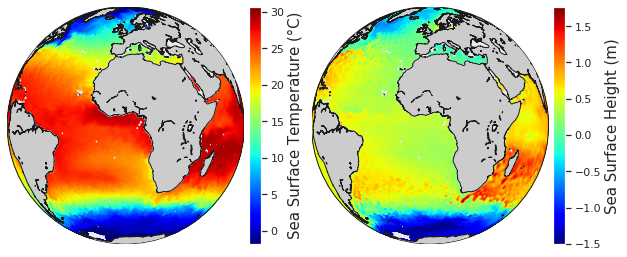

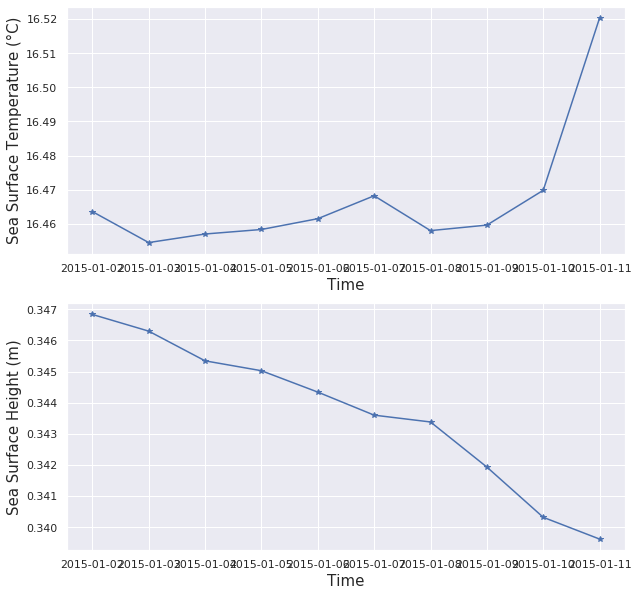

In [0]:
# plot global SST and SSH maps
sst_im=data.groupby(['lon','lat'])['sst'].mean()
ssh_im=data.groupby(['lon','lat'])['ssh'].mean()
lon_im=data.groupby(['lon','lat'])['lon'].mean()
lat_im=data.groupby(['lon','lat'])['lat'].mean()
figure()
subplot(1,2,1)
plot_im(lon_im,lat_im,sst_im,1,'Sea Surface Temperature (°C)')
subplot(1,2,2)
plot_im(lon_im,lat_im,ssh_im,1,'Sea Surface Height (m)')

# plot global SST and SSH time series
sst_ts=data.groupby(['time'])['sst'].mean()
ssh_ts=data.groupby(['time'])['ssh'].mean()
time_ts=data.groupby(['time'])['time'].mean()
figure()
subplot(2,1,1)
plot_ts(time_ts,sst_ts,'-*','Sea Surface Temperature (°C)')
subplot(2,1,2)
plot_ts(time_ts,ssh_ts,'-*','Sea Surface Height (m)')

In [0]:
sst_med_ts=data_med.groupby(['time'])['sst'].mean()
ssh_med_ts=data_med.groupby(['time'])['ssh'].mean()
time_med_ts=data_med.groupby(['time'])['time']

Now, we consider only a small region of the Globe: the Mediterranean Sea. As previously, we plot the mean time series and maps of SST and SSH. We also plot the SSH as a function of SST and the 2 distributions using histograms.

Text(0, 0.5, 'Sea Surface Height (m)')

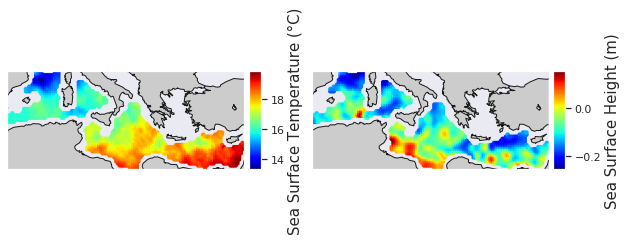

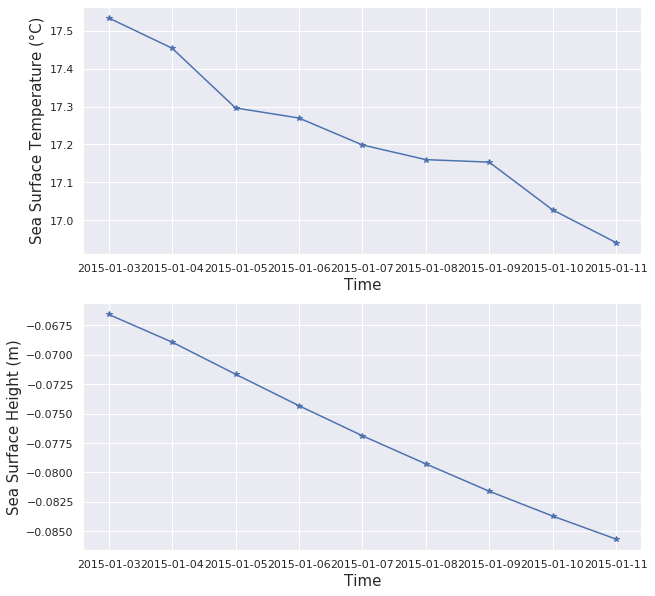

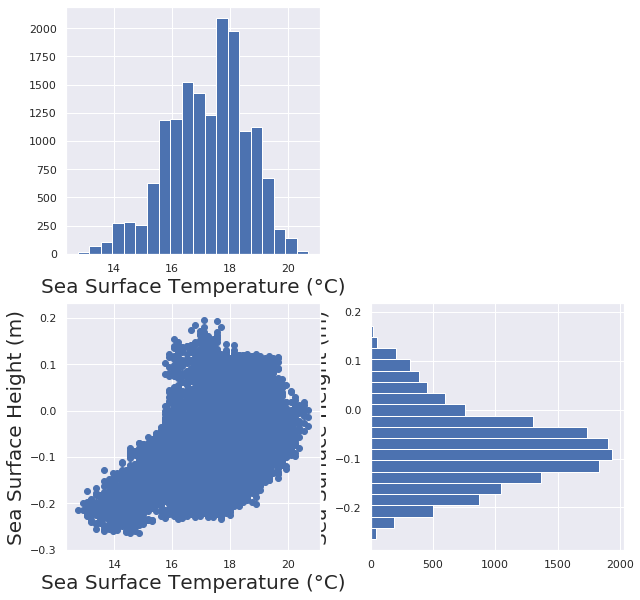

In [0]:
# data selection

data_med=data[(data.lon>0) & (data.lon<35) & (data.lat>30) & (data.lat<45) ]

# plot SST and SSH maps
sst_med_im=data_med.groupby(['lon','lat'])['sst'].mean()
ssh_med_im=data_med.groupby(['lon','lat'])['ssh'].mean()
lon_med_im=data_med.groupby(['lon','lat'])['lon'].mean()
lat_med_im=data_med.groupby(['lon','lat'])['lat'].mean()
figure()
subplot(1,2,1)
plot_im(lon_med_im,lat_med_im,sst_med_im,20,'Sea Surface Temperature (°C)')
subplot(1,2,2)
plot_im(lon_med_im,lat_med_im,ssh_med_im,20,'Sea Surface Height (m)')

# plot SST and SSH time series
sst_med_ts=data_med.groupby(['time'])['sst'].mean()
ssh_med_ts=data_med.groupby(['time'])['ssh'].mean()
time_med_ts=data_med.groupby(['time'])['time'].mean()
figure()
subplot(2,1,1)
plot_ts(time_med_ts,sst_med_ts,'-*','Sea Surface Temperature (°C)')
subplot(2,1,2)
plot_ts(time_med_ts,ssh_med_ts,'-*','Sea Surface Height (m)')

# plot hist(SST), hist(SSH), SSH~SST
figure()
subplot(2,2,1)
hist(data_med.sst, 20)
xlabel('Sea Surface Temperature (°C)', size=20)
subplot(2,2,4)
hist(data_med.ssh, 20, orientation=u'horizontal')
ylabel('Sea Surface Height (m)', size=20)
subplot(2,2,3)
scatter(data_med.sst, data_med.ssh)
xlabel('Sea Surface Temperature (°C)', size=20)
ylabel('Sea Surface Height (m)', size=20)

**Remark:**

The dataset used above is small (250Mo) and corresponds only to 10 days. Now, we want to manipulate the full database of 5 years (50Go) using big data tools. This database is stored in the Google Cloud Platform.

**Part 2) Manipulation of the full database using BigQuery**





In [0]:
from google.colab import auth
auth.authenticate_user()

Here, we plot the mean SST map in the Mediterranean Sea over the period 2011-2015. The full 5-years dataset is stored in the BigQuery table *bdo2020.bdo2020.2011_2015*. The project is called *alert-ground-261008* (strange but you have to provide it). The result of the BigQuery request is stored in the *output* dataframe. 

In [0]:
%%bigquery --project alert-ground-261008 output
SELECT lon, lat, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.2011_2015
WHERE lon>0 AND lon<35 AND lat>30 AND lat<45
GROUP BY lon, lat

In [0]:
# sample of the dataframe
output

,lon,lat,mean_sst
0,30.625,33.625,22.129929
1,29.375,33.875,21.675575
2,30.125,33.875,21.822043
3,21.625,34.125,21.419277
4,28.625,34.125,21.276177
...,...,...,...
1718,25.375,34.375,21.948631
1719,28.875,32.125,22.427136
1720,16.125,35.875,21.000082
1721,19.625,36.625,21.121084


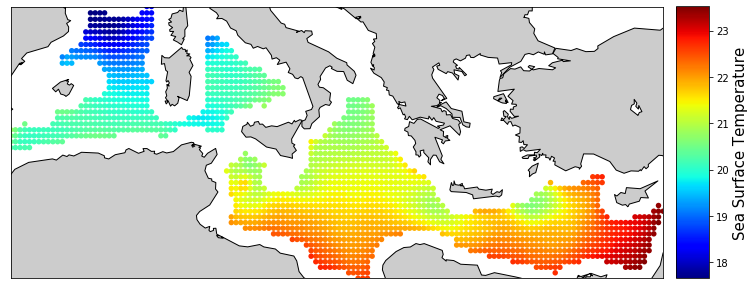

In [0]:
plot_im(output.lon,output.lat,output.mean_sst,30,'Sea Surface Temperature')

SQL language is suitable to manipulate and compute basic statistics such as the mean, standard deviation, minimum, maximum, correlation, etc... Here you will find the list of basic functions: https://cloud.google.com/bigquery/docs/reference/legacy-sql?hl=fr.

**1) Correlation map over the period 2011-2015 between SST and SSH in the Agulhas current, between longitudes (+15,+70) and latitudes (-50,-30).**

In [0]:
%%bigquery --project alert-ground-261008 output

SELECT lon, lat, Corr(sst, ssh) AS correlation
FROM bdo2020.bdo2020.2011_2015
WHERE lon>15 AND lon<70 AND lat>-50 AND lat<-30
GROUP BY lon, lat

In [0]:
correlation_mat = output.pivot("lat", "lon", "correlation"); correlation_mat

lon,15.125,15.375,15.625,15.875,16.125,16.375,16.625,16.875,17.125,17.375,17.625,17.875,18.125,18.375,18.625,18.875,19.125,19.375,19.625,19.875,20.125,20.375,20.625,20.875,21.125,21.375,21.625,21.875,22.125,22.375,22.625,22.875,23.125,23.375,23.625,23.875,24.125,24.375,24.625,24.875,...,60.125,60.375,60.625,60.875,61.125,61.375,61.625,61.875,62.125,62.375,62.625,62.875,63.125,63.375,63.625,63.875,64.125,64.375,64.625,64.875,65.125,65.375,65.625,65.875,66.125,66.375,66.625,66.875,67.125,67.375,67.625,67.875,68.125,68.375,68.625,68.875,69.125,69.375,69.625,69.875
lat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-49.875,0.403847,0.371824,0.321668,0.295082,0.296910,0.297028,0.298417,0.301171,0.288324,0.247917,0.191021,0.153641,0.151017,0.178815,0.201230,0.183528,0.132731,0.070118,0.016666,-0.027138,-0.056127,-0.067168,-0.042647,0.002566,0.050849,0.115153,0.198502,0.269373,0.309466,0.322086,0.322597,0.312615,0.297675,0.287507,0.268730,0.259874,0.293709,0.359254,0.412205,0.449226,...,0.462076,0.482981,0.507332,0.527047,0.532677,0.522350,0.523706,0.546835,0.586416,0.613507,0.618793,0.617662,0.603065,0.584424,0.558345,0.539594,0.513717,0.482995,0.465168,0.469422,0.481858,0.484381,0.487855,0.503907,0.532755,0.566478,0.602539,0.632321,0.660265,0.671006,0.678809,0.686041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-49.625,0.361229,0.320208,0.262180,0.243872,0.258902,0.254967,0.254801,0.257136,0.258177,0.252473,0.252042,0.258676,0.292201,0.335734,0.351733,0.319405,0.257923,0.163964,0.060216,-0.034759,-0.091823,-0.105202,-0.066884,0.000484,0.072531,0.151540,0.238407,0.326479,0.397030,0.423315,0.419480,0.388606,0.339909,0.293124,0.249585,0.236384,0.248761,0.289281,0.344626,0.393363,...,0.450006,0.479840,0.507448,0.525262,0.539439,0.551215,0.562479,0.584789,0.612382,0.624326,0.599616,0.563439,0.523443,0.489186,0.460263,0.445260,0.436188,0.434429,0.452881,0.488094,0.521793,0.538688,0.543158,0.556980,0.590145,0.626809,0.662312,0.682780,0.692986,0.693323,0.695646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-49.375,0.302978,0.259635,0.216544,0.207022,0.226814,0.229018,0.197355,0.198228,0.231074,0.274736,0.319503,0.358551,0.415180,0.452964,0.462578,0.438648,0.375560,0.272100,0.140842,0.019179,-0.064163,-0.084287,-0.053127,0.002217,0.066929,0.150000,0.253096,0.361165,0.439640,0.468424,0.448262,0.389721,0.307329,0.222978,0.158195,0.138632,0.153062,0.195001,0.263392,0.330051,...,0.477187,0.503494,0.531886,0.557761,0.593318,0.627400,0.648932,0.659653,0.660699,0.637238,0.584827,0.515170,0.443052,0.390738,0.363364,0.362314,0.382867,0.424758,0.484314,0.541932,0.584659,0.602951,0.606128,0.617993,0.644285,0.676041,0.699006,0.714970,0.715391,0.707557,0.707355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-49.125,0.239710,0.212294,0.191702,0.183040,0.185725,0.174216,0.141295,0.156069,0.219912,0.302598,0.373127,0.430422,0.484283,0.525641,0.535127,0.521323,0.482326,0.394562,0.259969,0.121612,0.013495,-0.052756,-0.056856,-0.017332,0.035405,0.107930,0.218502,0.339384,0.431005,0.448857,0.414696,0.336777,0.231932,0.120499,0.031725,0.004295,0.030000,0.099255,0.190680,0.260497,...,0.489840,0.521383,0.565768,0.610133,0.655632,0.699483,0.721816,0.716593,0.686837,0.648238,0.589151,0.504282,0.417848,0.351949,0.323808,0.335789,0.382736,0.458247,0.533505,0.589806,0.622770,0.639209,0.643128,0.651793,0.667613,0.685487,0.705281,0.717578,0.717410,0.707930,0.696089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-48.875,0.181912,0.185778,0.184767,0.172023,0.151296,0.126636,0.107890,0.140217,0.224625,0.321982,0.409887,0.473820,0.526666,0.565436,0.580481,0.568843,0.529318,0.451362,0.329569,0.200547,0.084410,0.000690,-0.039629,-0.027035,0.020961,0.083827,0.170636,0.281948,0.378891,0.420033,0.400158,0.339411,0.241832,0.127660,0.031941,0.010030,0.058401,0.135333,0.209903,0.264250,...,0.481834,0.520649,0.585170,0.646949,0.699000,0.728982,0.724125,0.689154,0.651098,0.621446,0.577761,0.518317,0.448544,0.385443,0.365275,0.382874,0.438457,0.515654,0.569475,0.602734,0.620122,0.627067,0.628532

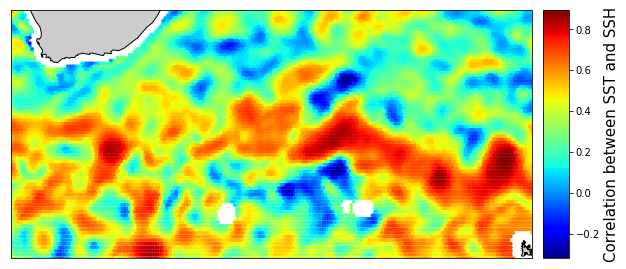

In [0]:
plot_im(output.lon,output.lat,output.correlation,15,'Correlation between SST and SSH')

**2*)*: Dealy mean and standard deviation time series of SST for the period 2011-2015 in the Equatorial Pacific, between longitudes (+180,+300) and latitudes (-20,+20). The mean SST time series is called the ENSO index and is used to identify El Nino and La Nina events.

In [0]:
%%bigquery --project alert-ground-261008 time_series

SELECT time, AVG(sst) AS mean_sst, STDDEV_POP(sst) as std_sst
FROM bdo2020.bdo2020.2011_2015
WHERE lon>180 AND lon<300 AND lat>-20 AND lat<20
GROUP BY time
Order by time

Text(0.5, 1.0, 'Mean')

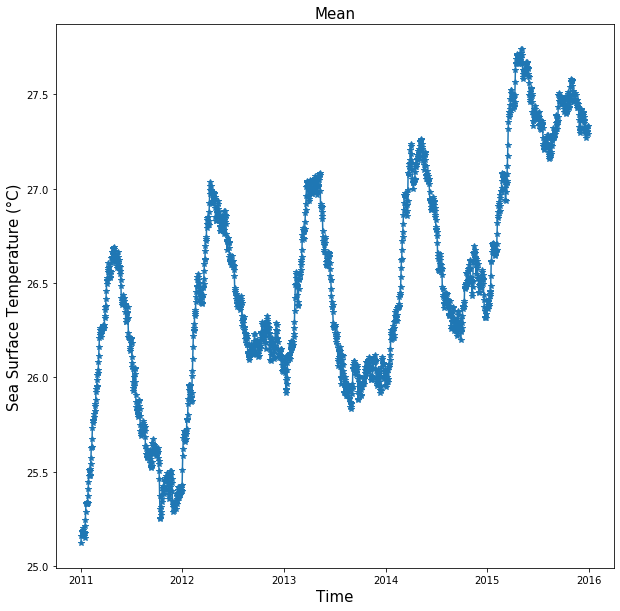

In [0]:
sst_ts=time_series['mean_sst']
sst_std = time_series['std_sst']
time_ts=time_series['time']
plot_ts(time_series['time'], sst_ts, '-*','Sea Surface Temperature (°C)' )
title('Mean',fontsize=15)


Text(0.5, 1.0, 'Standard Deviation')

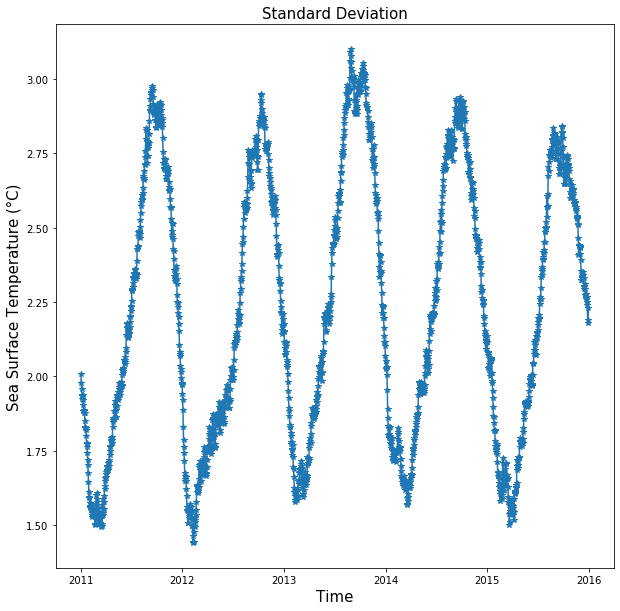

In [0]:
plot_ts(time_series['time'], sst_std, '-*','Sea Surface Temperature (°C)' )
title('Standard Deviation',fontsize=15)


**3)** The mean seasonal cycle of the SST and SSH in the Red Sea, between longitudes (+32,+45) and latitudes (+13,+30). This sea is the warmest in the world Over the years 2011-2015. 

In [0]:
debut = date2num(datetime.datetime(2011, 1, 1))
fin = date2num(datetime.datetime(2011, 1, 12))

In [0]:
seasonal

,time,mean_sst,mean_ssh
0,734138.0,28.274138,0.831652
1,734139.0,28.339655,0.831454
2,734140.0,28.174138,0.836772
3,734141.0,28.153448,0.846668
4,734142.0,28.220690,0.856703
...,...,...,...
1821,735959.0,27.536207,0.748803
1822,735960.0,27.500000,0.753136
1823,735961.0,27.305172,0.761415
1824,735962.0,26.982759,0.772107


In [0]:
pylab.rcParams['figure.figsize']=(20,5) # graph size

In [0]:
%%bigquery --project alert-ground-261008 seasonal

SELECT time, AVG(sst) AS mean_sst, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.2011_2015
WHERE lon>32 AND lon<45 AND lat>13 AND lat<30 
GROUP BY time
ORDER BY time

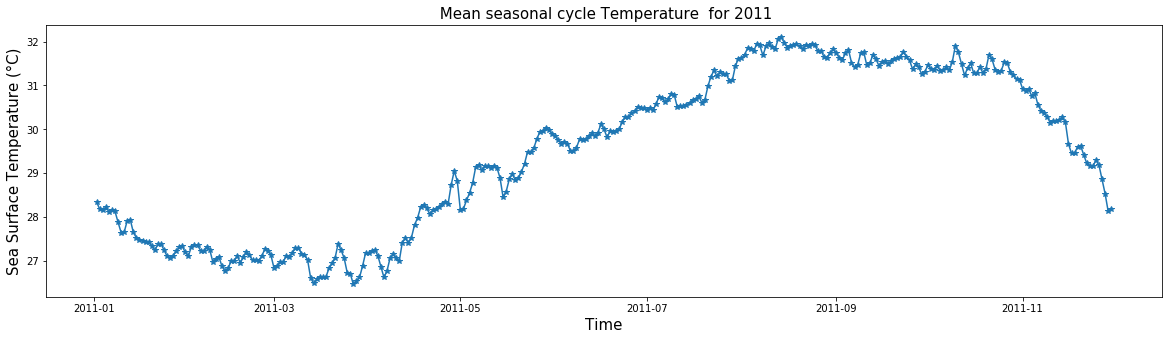

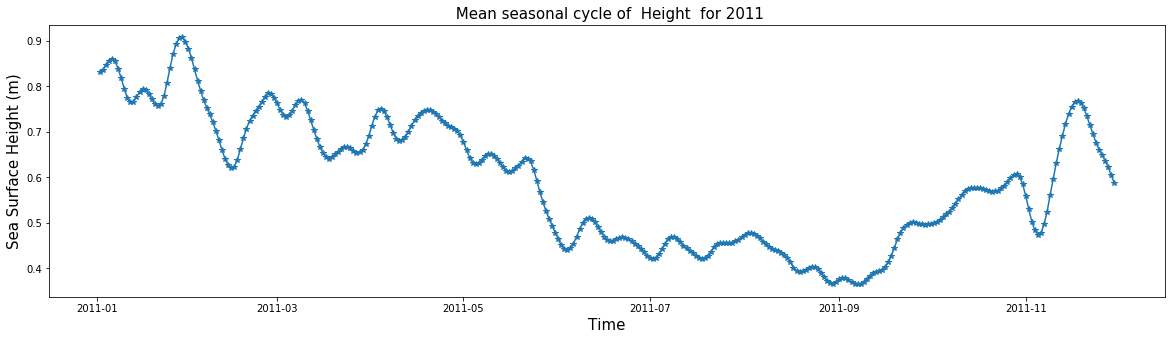

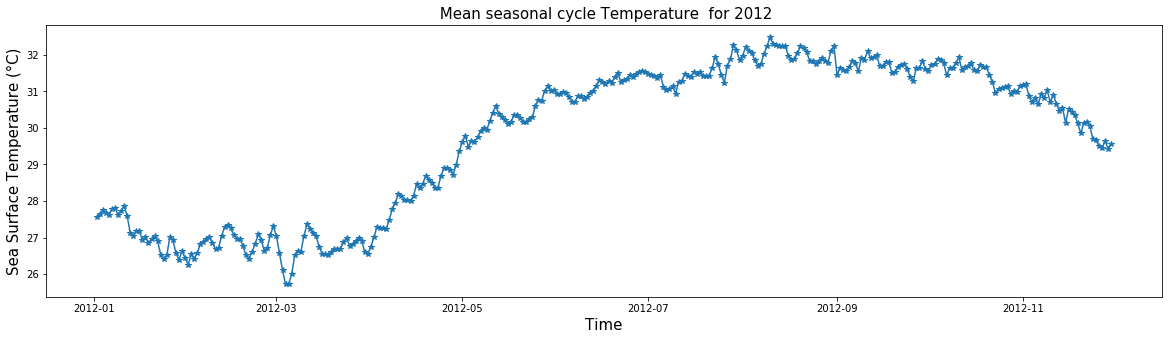

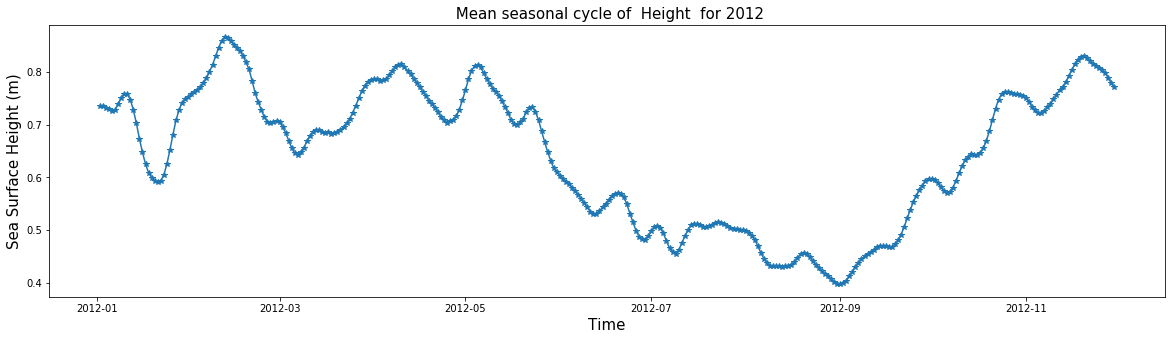

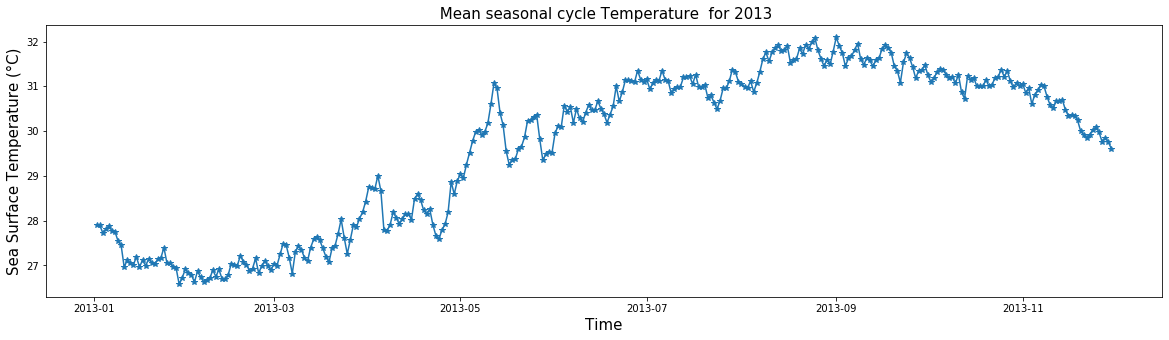

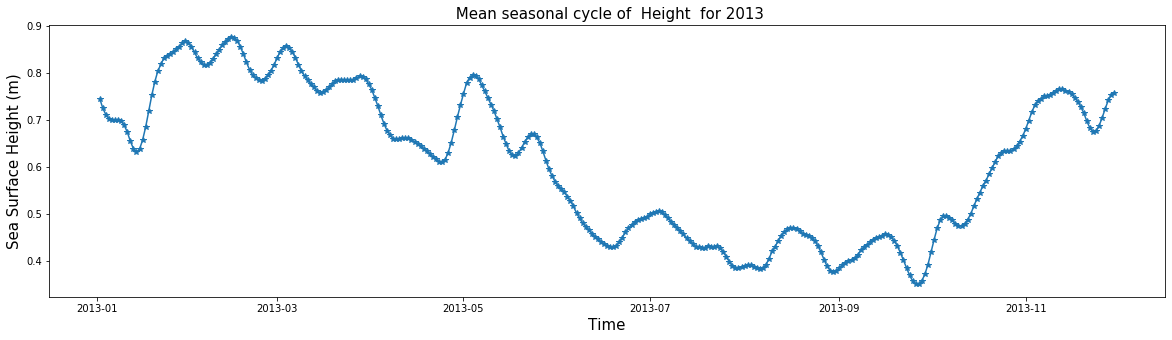

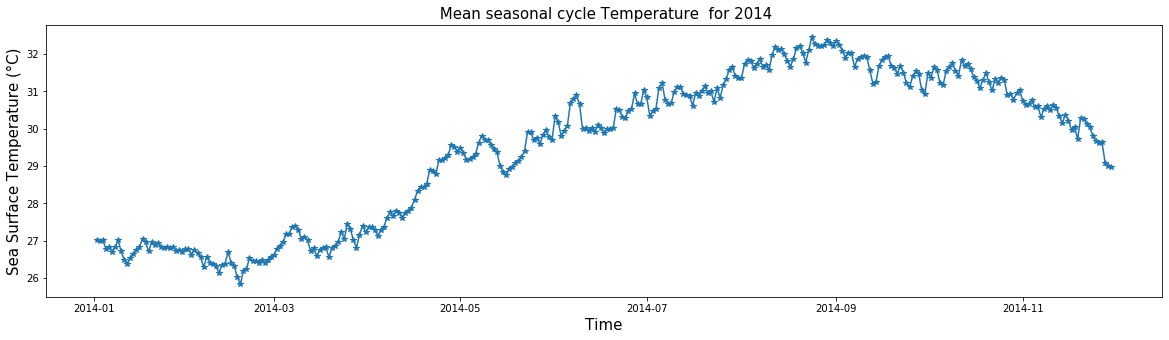

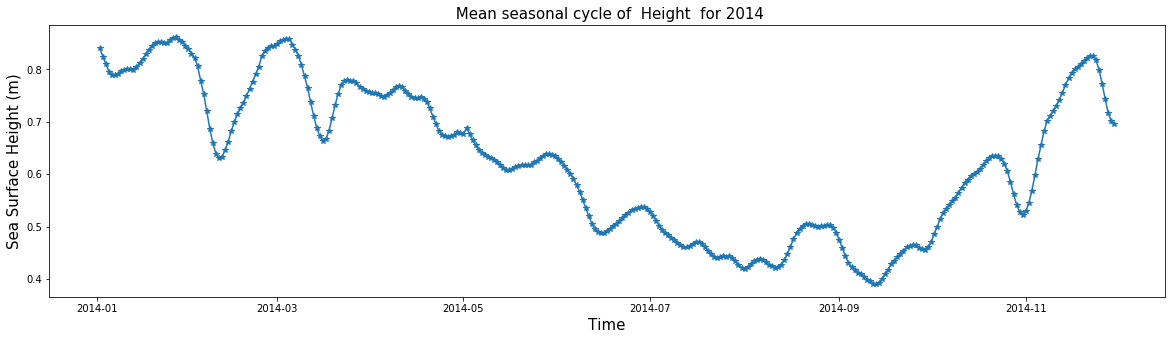

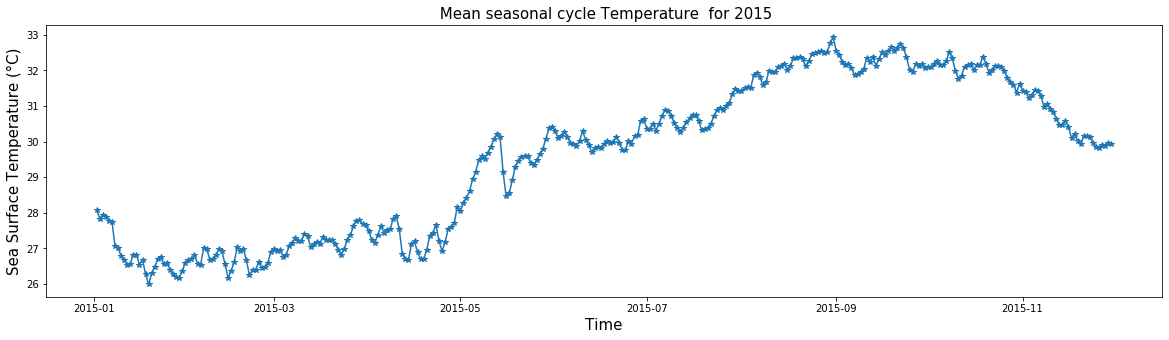

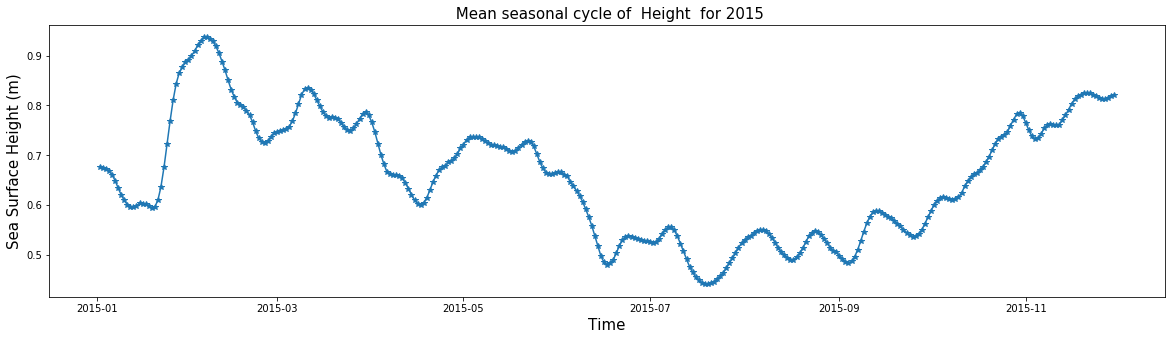

In [0]:
for i in range(5):
  debut = date2num(datetime.datetime(2011+i, 1, 1))
  fin = date2num(datetime.datetime(2011+i, 12, 1))
  data=seasonal[(seasonal.time>debut) & (seasonal.time<fin) ]
  plot_ts(data['time'], data['mean_sst'], '-*','Sea Surface Temperature (°C)' )
  title(' Mean seasonal cycle Temperature  for 201'+str(1+i),fontsize=15)

  plt.show()
  plot_ts(data['time'], data['mean_ssh'], '-*','Sea Surface Height (m)' )
  title(' Mean seasonal cycle of  Height  for 201'+str(1+i),fontsize=15)

  plt.show()

Text(0.5, 1.0, ' mean seasonal cycle Temperature (°C) between 2011 and 2015')

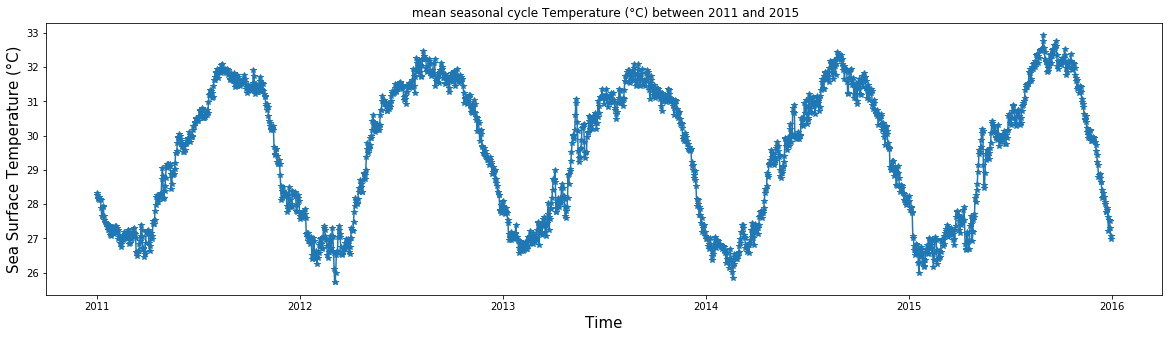

In [0]:
mean_seas = seasonal.groupby(['time'])['mean_sst'].mean()
plot_ts(seasonal.groupby(['time'])['time'].mean(), mean_seas, '-*','Sea Surface Temperature (°C)' )
title(' mean seasonal cycle Temperature (°C) between 2011 and 2015')


**4)**: The dealy time series of SST over the period 2011-2015 in the Gulf of Mexico, between longitudes (+263,+281) and latitudes (+17,+35). In this region, there are a lot of hurricanes and they use the energy of the sea (hot waters) to get stronger. Thus, after a hurricane, we see a rapid decrease of the SST. Plot the time series of the difference of SST between 2 consecutive days and check that the negative peaks correspond to well known hurricanes.

In [0]:
%%bigquery --project alert-ground-261008 Mexico

SELECT time, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.2011_2015
WHERE lon>263 AND lon<281 AND lat>17 AND lat<35
GROUP BY time
ORDER BY time

In [0]:
lag = 1

In [0]:
time_=Mexico['time']
diff = Mexico['mean_sst'][0:-lag].values- Mexico['mean_sst'][lag:].values

In [0]:
pylab.rcParams['figure.figsize']=(10,15) # graph size

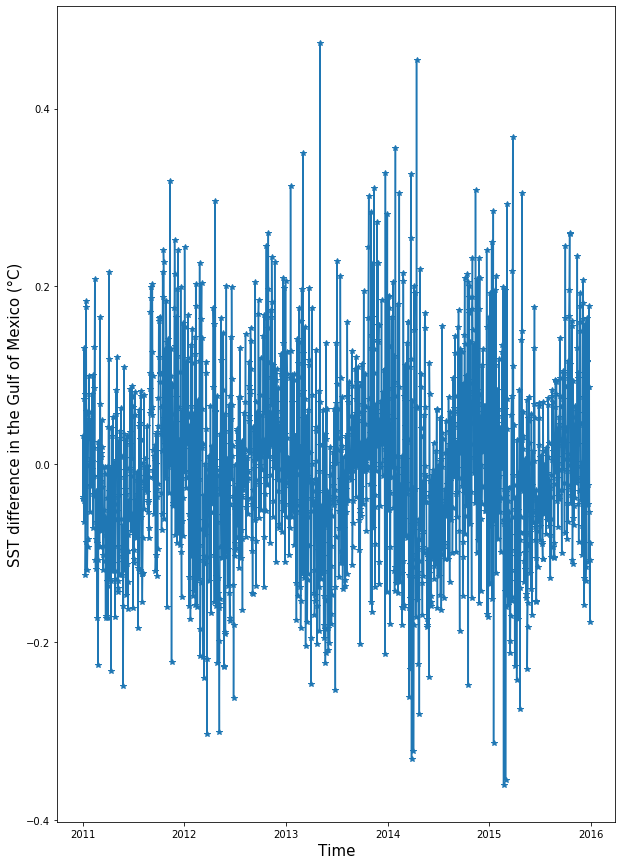

In [0]:
plot_ts(Mexico.time[0:-1],diff,'-*','SST difference in the Gulf of Mexico (°C)')

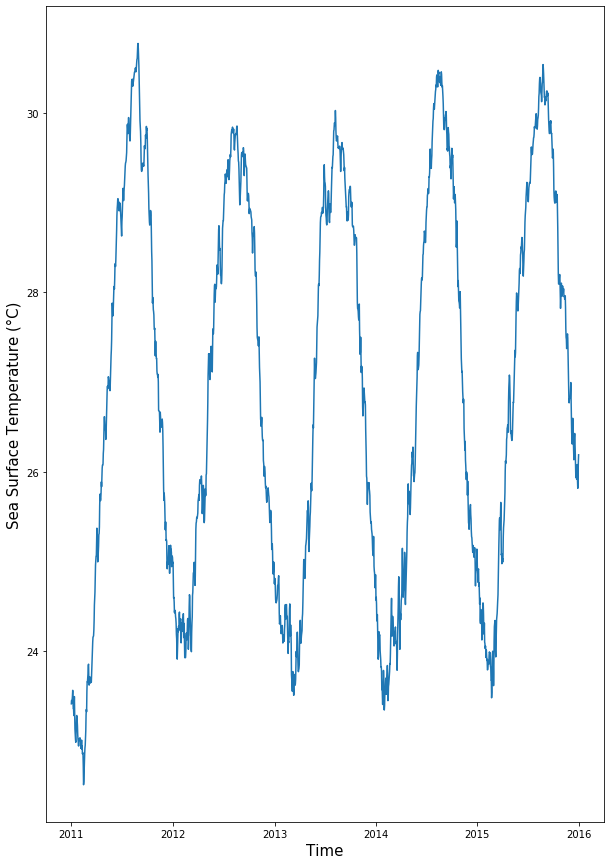

In [0]:

plot_ts(Mexico.time, Mexico.mean_sst, '-','Sea Surface Temperature (°C)' )



**Part 3) Combination of BigQuery and scikit-learn**

Now, we will extract data using BigQuery and apply regressions (using scikit-learn) on these extracted data. 



**5)** We Model the daily mean SST in the Mediterranean Sea using a linear tendancy and a one-year seasonal cycle such that: $SST(t)=\alpha_0 + \alpha_1 t + \alpha_2 sin(2\pi\omega t) + \alpha_3 cos(2\pi\omega t)$, with $\omega=\frac{1}{365}$. 
The corresponding observed and predicted SST time series.

In [0]:
%%bigquery --project alert-ground-261008 Data_med
SELECT time, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.2011_2015
WHERE lon>0 AND lon<35 AND lat>30 AND lat<45
GROUP BY time
ORDER BY time

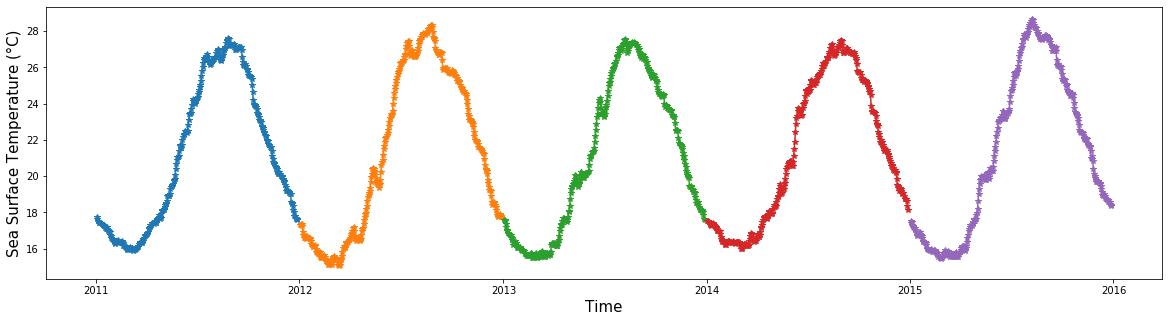

In [0]:
for i in range(5):
  debut = date2num(datetime.datetime(2011+i, 1, 1))
  fin = date2num(datetime.datetime(2011+i, 12, 29))
  data=Data_med[(Data_med.time>debut) & (Data_med.time<fin) ]
  plot_ts(data['time'], data['mean_sst'], '-*','Sea Surface Temperature (°C)' )
 

In [0]:
time = Data_med['time'].values

In [0]:
w = 1/365
one = np.ones_like(time)
sin = np.sin(2*pi*w*time)
cos = np.cos(2*pi*w*time)
X = np.vstack((one, time, sin, cos)).T

In [0]:
y = Data_med['mean_sst'].values

In [0]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4,shuffle = False, random_state=42)

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)


0.9794118040653292

In [0]:
reg.coef_

array([ 0.00000000e+00, -3.78690461e-04, -6.49305960e-01,  5.85637298e+00])

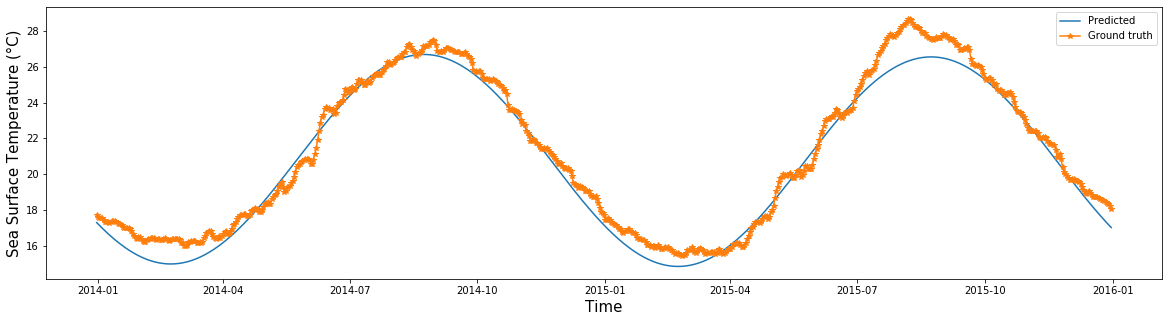

In [0]:
time_test = X_test.T[1]
y_pred = reg.predict(X_test)

plot_ts(time_test, y_pred, '-','Sea Surface Temperature (°C)' )
plot_ts(time_test, y_test, '-*','Sea Surface Temperature (°C)' )
plt.legend(['Predicted', 'Ground truth'])


**QUESTION 6**: Here we compute the SSH difference between the first day in 2011 and the last day in 2015, and  plot this difference at each location in the globe. Finally, using a regression (linear or not), we make a prediction of the global sea level rise (averaged over all the location) for the horizon 2100. 

In [0]:
debut = date2num(datetime.datetime(2011, 1, 1))
fin = date2num(datetime.datetime(2015, 12, 31))

In [0]:
print(debut,fin)

734138.0 735963.0


In [0]:
%%bigquery --project alert-ground-261008 begining
SELECT lon, lat, ssh
FROM bdo2020.bdo2020.2011_2015
WHERE time=734138.0
GROUP BY lon, lat, ssh

In [0]:
%%bigquery --project alert-ground-261008 end
SELECT lon, lat, ssh
FROM bdo2020.bdo2020.2011_2015
WHERE time=735963.0
GROUP BY lon, lat, ssh

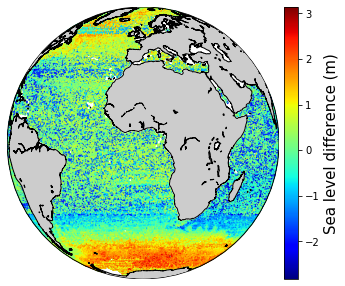

In [0]:
plot_im(end.lon,end.lat,begining.ssh-end.ssh,2,'Sea level difference (m)')

In [0]:
%%bigquery --project alert-ground-261008 data_reg
SELECT time, AVG(ssh) AS ssh_mean
FROM bdo2020.bdo2020.2011_2015
GROUP BY time
ORDER BY time

In [0]:
X= array([data_reg.time]).T
y=data_reg.ssh_mean

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4,shuffle = False, random_state=42)

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.22172153389592442

In [0]:
reg.score(X_test, y_test)

0.07016359081659518

In [0]:

X_pred=array([arange(min(data_reg.time),max(data_reg.time)+85*365)]).T
y_pred=reg.predict(X_pred)

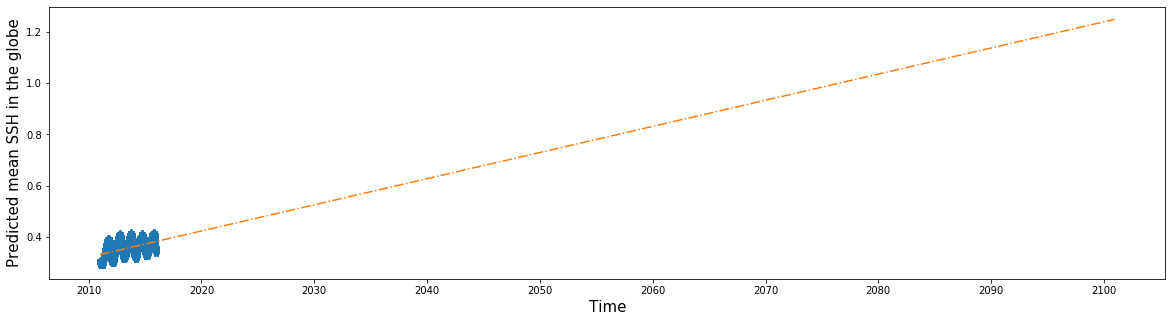

In [0]:
plot_ts(data_reg.time,data_reg.ssh_mean,'-*','Mean SSH in the globe')
plot_ts(X_pred,y_pred,'-.','Predicted mean SSH in the globe')